### **MODEL BUILDING**

In this section, we aim to build machine learning models that can accurately predict employee attrition and help identify the key factors contributing to it. Understanding these factors is essential for organizations to proactively address employee turnover and improve retention strategies.

We will use:

* **Random Forest Classifier**: A powerful ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction. It is particularly useful for handling imbalanced datasets and capturing non-linear relationships.

We will train and evaluate both models on the dataset and compare their performance based on key metrics such as:

* Accuracy
* Precision
* Recall
* F1-Score
* AUC-ROC

Additionally, we will use feature importance scores to identify which variables most strongly influence the likelihood of employee attrition.

In [2]:
 # Importing necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency ,fisher_exact
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score , recall_score , f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

In [3]:
 # Setting up the visualization style 
sns.set_style( style = 'darkgrid' )
sns.set_palette( palette = 'icefire' )

 # Loading the Dataset 
DATA = pd.read_csv( 'HR_Employee_Attrition.csv' )

display(DATA)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


Before training our models, we need to convert categorical variables into a numerical format that machine learning algorithms can interpret. To achieve this, we will use Label Encoding, which transforms categorical text data into integer values. This method is particularly suitable for tree-based models like Random Forest and XGBoost, as they do not assume any ordinal relationship between the encoded values. Converting categorical data into numerical values is a crucial preprocessing step that enables the model to accurately capture patterns and relationships within the data, ultimately enhancing classification performance.

In [4]:
 # Label Encoding
cat_columns = [ 'Gender' , 'Attrition' , 'OverTime' , 'MaritalStatus' , 'Department' , 'BusinessTravel' , 'EducationField' , 'JobRole' ]

label_encoder = preprocessing.LabelEncoder()

 # creating a for loop for encoding
for i in cat_columns:

    DATA[i] = label_encoder.fit_transform( DATA[i] )

display( DATA[cat_columns] )


,Gender,Attrition,OverTime,MaritalStatus,Department,BusinessTravel,EducationField,JobRole
0,0,1,1,2,2,2,1,7
1,1,0,0,1,1,1,1,6
2,1,1,1,2,1,2,4,2
3,0,0,1,1,1,1,1,6
4,1,0,0,1,1,2,3,2
...,...,...,...,...,...,...,...,...
1465,1,0,0,1,1,1,3,2
1466,1,0,0,1,1,2,3,0
1467,1,0,1,1,1,2,1,4
1468,1,0,0,1,2,1,3,7


Next, we will drop the columns Over18, EmployeeCount, and StandardHours, as they hold the same value for all records and do not contribute any meaningful variance to the model. Including such features would add noise without improving predictive performance. Additionally, we will remove the EmployeeNumber column, as it is a unique identifier assigned randomly to each employee and does not contain any predictive information related to attrition. Removing these non-informative columns helps streamline the dataset and improves model efficiency

In [5]:
 # Dropping the columns
DATA.drop(columns = 'Over18', inplace = True ) 
DATA.drop(columns = 'EmployeeNumber', inplace = True ) 
DATA.drop(columns = 'EmployeeCount', inplace = True ) 
DATA.drop(columns = 'StandardHours', inplace = True ) 


In [6]:
 # Dividing the Data into Dependant and Independent variables 
X = DATA.drop( columns = 'Attrition')
y = DATA['Attrition']

 # Splitting the data into training and testing data 
X_train,X_test,y_train,y_test = train_test_split( X , y ,test_size = 0.2 , random_state = 21 )

After splitting the data into training and testing sets, we will apply SMOTE (Synthetic Minority Over-sampling Technique) to address the class imbalance observed during our Exploratory Data Analysis (EDA). Since the dataset is imbalanced — with significantly fewer employees labeled as having left the company (Attrition = Yes) — applying SMOTE will help create synthetic examples of the minority class in the training set. This ensures that the model does not become biased toward the majority class, leading to improved generalization and better performance in identifying attrition cases.

In [7]:
 # oversampling the train dataset using SMOTE
smt = SMOTE( random_state = 42 )
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print('X_Train_Shape : ', X_train_sm.shape , '    y_Train_Shape : ', y_train_sm.shape )

y_train_sm.value_counts().to_frame()

X_Train_Shape :  (1972, 30)     y_Train_Shape :  (1972,)


,count
Attrition,
0,986
1,986


In [ ]:
 # Creating the Classifier 
classifier = RandomForestClassifier(n_estimators=10, random_state=42 )

gr_space = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(classifier, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit( X_train_sm , y_train_sm )


In [9]:
# Get the best parameters from the grid search
best_params = model_grid.best_params_
print(f"Best Parameters: {best_params}")

# Get the best estimator (fitted model)
rf_model = model_grid.best_estimator_

Best Parameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 400}


Accuracy on the Training Data :  0.9889455782312925 
Accuracy on Testing Data :  0.8061224489795918 
 Precision Score :  0.4 
 Sensitivity Score :  0.425531914893617 
 F1 Score :  0.41237113402061853


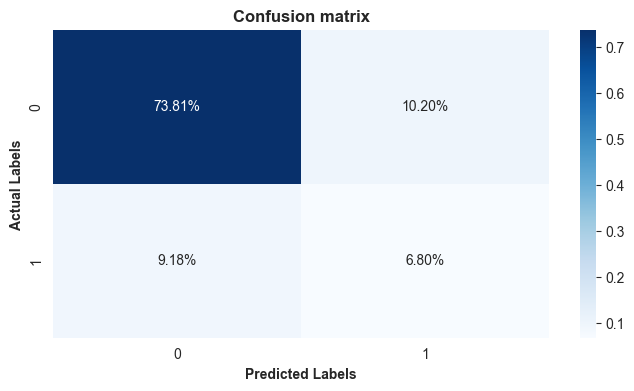

In [10]:
 # Predicting the y_test using the model
y2_pred = rf_model.predict( X_test )

 # Predicting the Training Data
y_train_pred = rf_model.predict( X_train )

 # Getting the accuracy  
print( 'Accuracy on the Training Data : ' , accuracy_score( y_train , y_train_pred ) ,'\n'  'Accuracy on Testing Data : ' ,  accuracy_score( y_test , y2_pred ) , '\n' , 'Precision Score : ' , precision_score( y_test , y2_pred ) , '\n' , 'Sensitivity Score : ' , recall_score( y_test , y2_pred ) , '\n' , 'F1 Score : ' , f1_score( y_test , y2_pred ) )

 # Plotting the confusion matrix 
c_matrix = confusion_matrix( y_test,y2_pred )

plt.figure( figsize = ( 8 , 4 ) )

sns.heatmap( c_matrix / np.sum( c_matrix ) , annot=True, 
            fmt='.2%', cmap='Blues')

plt.title('Confusion matrix', fontweight='bold')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('Actual Labels', fontweight='bold')

plt.show()

From the model evaluation metrics, we observe that the **Random Forest model** achieves an **accuracy of 80%**, indicating that it correctly predicts 80% of the employee attrition outcomes in the test dataset. This reflects strong overall performance in general classification.

* The model's **precision is 40%**, meaning that when the model predicts an employee will leave (Attrition = Yes), it is correct 40% of the time.
* The **recall (sensitivity)** is  at **42%**, suggesting the model only identifies 42% of all actual attrition cases.
* The **F1-score**, which balances precision and recall, stands at **41%**.

From the **confusion matrix**, we gain more insight into class-level performance:

* **73.81%** of employees who stayed are correctly classified as *non-left* (true negatives).
* **10.2%** of employees who stayed are incorrectly predicted as *left* (false positives).
* **9.8%** of employees who left are correctly identified as *left* (true positives).
* **6.80%** of employees who left are incorrectly classified as *non-left* (false negatives).

Overall, while the model performs well in identifying retained employees, it underperforms in identifying those who actually leave.

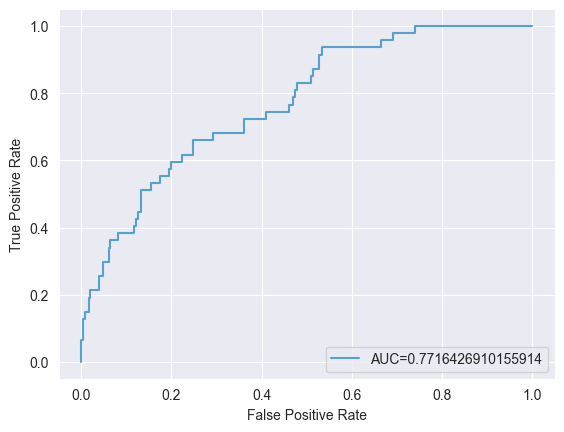

In [11]:
 # Plotting the ROC curve
y_pred_proba = rf_model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr , tpr , label = "AUC=" + str(auc) )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

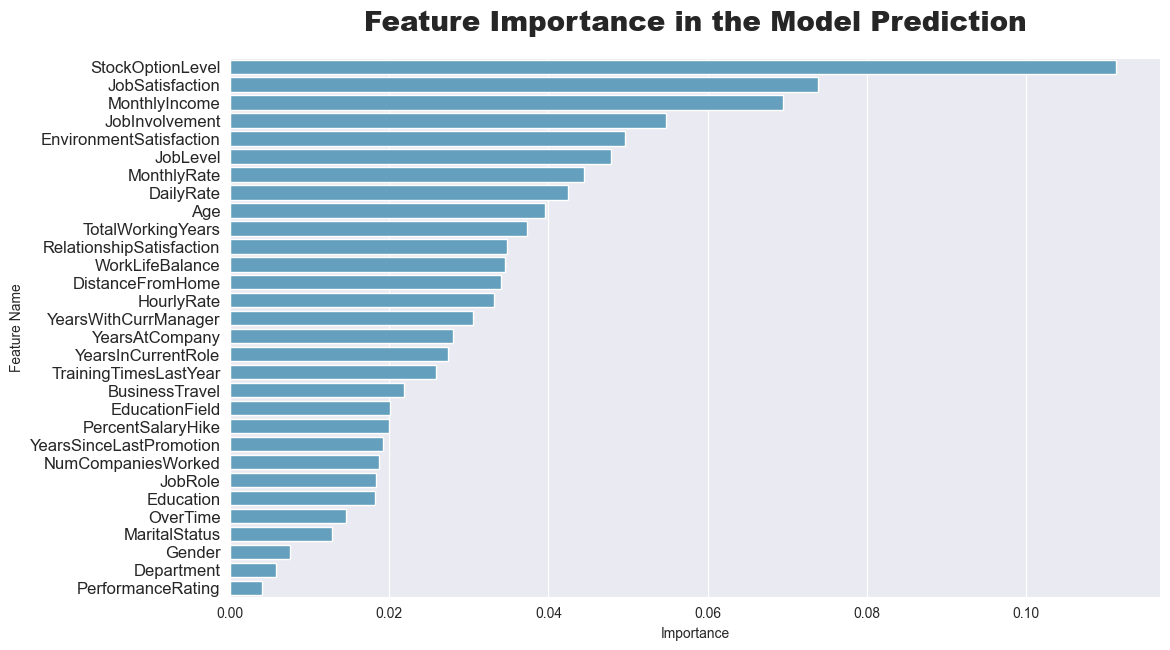

In [12]:
# Get feature importance
importance_df = pd.DataFrame({"Feature Name" : X_train.columns,         # changing into a dataframe 
                       "Importance" : rf_model.feature_importances_})

importances = importance_df.sort_values(by="Importance",ascending=False)

 # plotting the important features
plt.figure(figsize=(12,7))

sns.barplot(x="Importance", y="Feature Name", data = importances )

plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)

plt.yticks(size=12)

plt.show()

### **Model Feature Importance Insights**

From the model, we observe that the following are the **most influential features** contributing to employee attrition:

* **Stock Option Level**: Employees with stock options may feel more invested in the company, leading to higher retention.
* **Job Satisfaction**: A key driver of retention—lower satisfaction correlates with higher attrition.
* **Monthly Income**: Financial compensation significantly influences employee decisions to stay or leave.

On the other hand, the **least important features** in predicting attrition were:

* **Performance Rating**: Despite assumptions, performance scores did not strongly impact attrition likelihood.
* **Department**: The specific department had a relatively minor effect on attrition when other factors were considered.
* **Gender**: Gender was not a significant determinant of whether an employee left the company.

